# Preserving the structural similarity index for floating-point data (dSSIM) with safeguards

In this example, we compare the structural similarity index for floating-point data (dSSIM) [^1] after compressing a dataset of `u` wind with three different lossy compressors (ZFP, SZ3, SPERR). We then stress-test the quantity of interest (QoI) implementation of the safeguards by preserving an error bound on the dSSIM by translating the dSSIM computation into a quantity of interest, which involves rescaling and linearly quantizing values, applying a 2D Gaussian smoothing kernel, and computing variances and co-variances.

[^1]: Baker, A. H., Pinard, A. and Hammerling, D. M. (2024). On a Structural Similarity Index Approach for Floating-Point Data. *IEEE Transactions on Visualization and Computer Graphics*. 30(9), 6261-6274. Available from: [doi:10.1109/TVCG.2023.3332843](https://doi.org/10.1109/TVCG.2023.3332843).

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from collections import defaultdict
from pathlib import Path

import earthkit.plots
import humanize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = (
    ERA5["u"]
    .sel(valid_time="2024-04-02T12:00:00", pressure_level=500)
    .astype(np.float64)
)

In [4]:
ERA5_U.shape

(721, 1440)

In [5]:
def dssim_mat(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 3,
    reproducible: bool = True,
) -> np.ndarray:
    """
    Implementation adapted from the official dSSIM implementation at
    https://github.com/NCAR/ldcpy/blob/6c5bcb8149ec7876a4f53b0e784e9c528f6f14cb/ldcpy/calcs.py#L2516

    The official implementation makes assumptions about the input data that are
    specific to models developed at NCAR which is why we cannot use the official
    implementation directly.

    The implementation has been further adapted to ensure bit-reproducible
    evaluation with the below dSSIM quantity of interest, with the following
    notable changes:

    - we take extra care to ensure all operations are computed in the data
      dtype, i.e. without accidentally upcasting to np.float64
    - the original uses np.round, which rounds halfway cases away from zero,
      we use np.rint which rounds halfway cases to the nearest even integer
    - the original uses astropy.convolution.convolve, which internally upcasts
      to float64 - to avoid rounding differences, we manually implement it here
    - astropy.convolution.convolve handles NaN values by replacing them during
      convolution with a Gaussian kernel by interpolating with the same
      Gaussian kernel, to avoid NaNs bleeding over, and by returning NaN for
      elements that were NaN in the input. We implement a simpler version by
      excluding NaN values from the convolution and returning NaN for elements
      that were NaN in the input
    - convolution requires summation but np.sum internally uses partial sums
      for better rounding, which the safeguards currently do not use, so we
      manually sum
    - we reduce the 11x11 Gaussian kernel to 3x3 for the sake of compute time

    Parameters
    ----------
    x : np.ndarray
        Shape: (latitude, longitude)
    y : np.ndarray
        Shape: (latitude, longitude)
    kernel_size : int
        The size of the Gaussian kernel for the convolution operation in SSIM. Has to be
        an odd number. The default is 3.

    Returns
    -------
    dssim : np.ndarray
        The pointwise data-SSIM values where the k x k kernel is valid.
    """
    assert kernel_size % 2 == 1, "kernel_size must be an odd number."
    assert a1.shape == a2.shape
    assert a1.dtype == a2.dtype

    # re-scale  to [0,1] - if not constant
    smin = min(np.nanmin(a1), np.nanmin(a2))
    smax = max(np.nanmax(a1), np.nanmax(a2))
    r = smax - smin
    if r == 0:  # scale by smax if field is a constant (and smax != 0)
        if smax == 0:
            sc_a1 = a1
            sc_a2 = a2
        else:
            sc_a1 = a1 / smax
            sc_a2 = a2 / smax
    else:
        sc_a1 = (a1 - smin) / r
        sc_a2 = (a2 - smin) / r

    # now quantize to 256 bins
    sc_a1 = np.rint(sc_a1 * 255) / 255
    sc_a2 = np.rint(sc_a2 * 255) / 255

    # 2D gaussian filter
    sigma = a1.dtype.type(1.5)
    pi = a1.dtype.type(np.pi)

    i = np.arange(kernel_size).astype(a1.dtype) - (kernel_size // 2)
    k = 1 / (np.sqrt(2 * pi) * sigma) * np.exp((-np.square(i)) / (2 * np.square(sigma)))
    kernel = np.array([k]).T @ np.array([k])

    def convolve(a, k):
        # pad with zeros
        ap = np.pad(a, kernel_size // 2, mode="constant", constant_values=0)
        # reshape a to (*a.shape, *k.shape)
        av = np.lib.stride_tricks.as_strided(
            ap, a.shape + k.shape, ap.strides + ap.strides
        )

        # broadcast k to (*a.shape, *k.shape)
        kv = np.copy(
            np.broadcast_to(k.reshape((1, 1, kernel_size, kernel_size)), av.shape)
        )

        # exclude weights in kv where av is NaN
        kv[np.isnan(av)] = 0
        # renormalize kv
        kv_flat = kv.reshape(a.shape + (-1,))
        if reproducible:
            # manual np.sum over the last dimension
            kv_acc = np.copy(kv_flat[..., 0])
            for i in range(1, kv_flat.shape[-1]):
                kv_acc += kv_flat[..., i]
        else:
            kv_acc = np.sum(kv_flat, axis=-1)
        kv /= kv_acc.reshape(a.shape + (1, 1))

        # pointwise multiply av with kv, then reshape to (*a.shape, -1)
        ag = (av * kv).reshape(a.shape + (-1,))
        if reproducible:
            # manual np.sum over the last dimension
            acc = np.copy(ag[..., 0])
            for i in range(1, ag.shape[-1]):
                acc += ag[..., i]
        else:
            acc = np.sum(ag, axis=-1)

        # keep NaN for elements that are NaN in a
        return np.where(np.isnan(a), np.nan, acc)

    a1_mu = convolve(sc_a1, kernel)
    a2_mu = convolve(sc_a2, kernel)

    a1a1 = convolve(np.square(sc_a1), kernel)
    a2a2 = convolve(np.square(sc_a2), kernel)

    a1a2 = convolve(sc_a1 * sc_a2, kernel)

    ###########
    var_a1 = a1a1 - np.square(a1_mu)
    var_a2 = a2a2 - np.square(a2_mu)
    cov_a1a2 = a1a2 - a1_mu * a2_mu

    # ssim constants
    C1 = a1.dtype.type(eps)
    C2 = a1.dtype.type(eps)

    ssim_t1 = 2 * a1_mu * a2_mu + C1
    ssim_t2 = 2 * cov_a1a2 + C2

    ssim_b1 = np.square(a1_mu) + np.square(a2_mu) + C1
    ssim_b2 = var_a1 + var_a2 + C2

    ssim_1 = ssim_t1 / ssim_b1
    ssim_2 = ssim_t2 / ssim_b2
    ssim_mat = ssim_1 * ssim_2

    # Cropping the border region of the 2D field where the convolution kernel is not
    # fully overlapping with the 2D input field.
    k = (kernel_size - 1) // 2
    return ssim_mat[k : ssim_mat.shape[0] - k, k : ssim_mat.shape[1] - k]


def dssim(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 3,
    reproducible: bool = True,
) -> float:
    """
    Implementation adapted from the official dSSIM implementation at
    https://github.com/NCAR/ldcpy/blob/6c5bcb8149ec7876a4f53b0e784e9c528f6f14cb/ldcpy/calcs.py#L2516

    The official implementation makes assumptions about the input data that are
    specific to models developed at NCAR which is why we cannot use the official
    implementation directly.

    Parameters
    ----------
    x : np.ndarray
        Shape: (latitude, longitude)
    y : np.ndarray
        Shape: (latitude, longitude)
    kernel_size : int
        The size of the Gaussian kernel for the convolution operation in SSIM. Has to be
        an odd number. The default is 3.

    Returns
    -------
    dssim : float
        The data-SSIM value between the two input arrays.
    """
    return np.nanmean(
        dssim_mat(a1, a2, eps=eps, kernel_size=kernel_size, reproducible=reproducible)
    )

In [6]:
dssim(ERA5_U.values, ERA5_U.values, reproducible=False)

np.float64(1.0)

In [7]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [8]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [9]:
def compute_corrections_percentage(
    my_ERA5_U: xr.DataArray, orig_ERA5_U: xr.DataArray
) -> float:
    return np.mean(my_ERA5_U != orig_ERA5_U)

In [10]:
def plot_u_wind_dssim(
    my_ERA5_U: xr.DataArray,
    cr,
    chart,
    title,
    span,
    dssim_bound,
    error=False,
    corr=None,
    my_ERA5_U_it=None,
    cr_it=None,
):
    import copy

    import dask

    if error:
        err_inf_U = np.amax(np.abs(my_ERA5_U - ERA5_U))
        err_2_U = np.sqrt(np.mean(np.square(my_ERA5_U - ERA5_U)))

        with xr.set_options(keep_attrs=True):
            da = ERA5_U[1:-1, 1:-1].copy(
                data=dssim_mat(
                    ERA5_U.values,
                    my_ERA5_U.values,
                    reproducible=False,
                )
            )
            da.attrs.update(long_name=f"dSSIM({da.long_name})", units=None)

        dssim_mean = np.nanmean(da)
        dssim_min = np.nanmin(da)
        dssim_max = np.nanmax(da)

        err_v = np.mean(~(da >= dssim_bound))
    else:
        da = my_ERA5_U

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(*span, 22))
    style._legend_kwargs["ticks"] = np.linspace(*span, 5)

    if error:
        style._colors = "cool_r"

    extend_left = np.nanmin(da) < span[0]
    extend_right = np.nanmax(da) > span[1]

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)

        if corr is not None:
            with xr.set_options(keep_attrs=True):
                da_hatch = my_ERA5_U == corr

            da_hatch = da_hatch.copy(
                data=dask.array.from_array(da_hatch.values)
                .rechunk(4)
                .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                .compute()
            )

            with plt.rc_context(
                {
                    "hatch.color": (1.0, 1.0, 1.0, 1.0),
                    "hatch.linewidth": 0.5,
                }
            ):
                chart.contourf(
                    x=np.broadcast_to(
                        da_hatch.longitude.values.reshape(1, -1), da_hatch.shape
                    ),
                    y=np.broadcast_to(
                        da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape
                    ),
                    z=da_hatch.values,
                    colors=["none"],
                    levels=[-0.5, 0.9, 1.5],
                    hatches=["xxx" if corr is None else "O", None],
                    legend_style=None,
                    zorder=-11,
                )

            if my_ERA5_U_it is not None:
                with xr.set_options(keep_attrs=True):
                    da_hatch_it = my_ERA5_U_it == corr

                da_hatch_it = da_hatch_it.copy(
                    data=dask.array.from_array(da_hatch_it.values)
                    .rechunk(4)
                    .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                    .compute()
                )

                with plt.rc_context(
                    {
                        "hatch.color": (255 / 255, 215 / 255, 0 / 255, 1.0),
                        "hatch.linewidth": 0.25,
                    }
                ):
                    chart.contourf(
                        x=np.broadcast_to(
                            da_hatch_it.longitude.values.reshape(1, -1),
                            da_hatch_it.shape,
                        ),
                        y=np.broadcast_to(
                            da_hatch_it.latitude.values.reshape(-1, 1),
                            da_hatch_it.shape,
                        ),
                        z=da_hatch_it.values,
                        colors=["none"],
                        levels=[-0.5, 0.9, 1.5],
                        hatches=["O", None],
                        legend_style=None,
                        zorder=-11,
                    )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        corr_it = (
            None
            if (corr is None) or (my_ERA5_U_it is None)
            else compute_corrections_percentage(my_ERA5_U_it, corr)
        )

        corr = None if corr is None else compute_corrections_percentage(my_ERA5_U, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_inf_U:.03}  "
            + rf"$L_{{{{2}}}}(\hat{{{{u}}}})$={err_2_U:.03}  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                    + (
                        ""
                        if corr_it is None
                        else (
                            f" ({0 if corr_it == 0 else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + '%'})"
                        )
                    )
                )
            )
            + "\n"
            + rf"$dSSIM(u, \hat{{{{u}}}})$={dssim_mean:.05} ({dssim_min:.03} $\leq$ $dSSIM$ $\leq$ {dssim_max:.03})"
        )
    else:
        chart.title(f"{title}\n\n")

    t = chart.ax.text(
        0.95,
        0.9,
        (
            f"x {np.round(cr, 2)}"
            + ("" if cr_it is None else f" (x {np.round(cr_it, 2)})")
        )
        if error
        else humanize.naturalsize(ERA5_U.nbytes, binary=True),
        ha="right",
        va="top",
        transform=chart.ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(da.values.flatten(), range=span, bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    if error:
        if extend_left:
            cb._extend_patches[0].set_hatch("xx")
            cb._extend_patches[0].set_ec("white")
        cb.ax.fill_between(
            [span[0], dssim_bound],
            *cb.ax.get_ylim(),
            hatch="xx",
            ec="w",
            fc="none",
            lw=0,
        )
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
        **(
            dict(
                hatch=["xx" if np.abs(m) < dssim_bound else "" for m in midpoints],
                ec="white",
                lw=0,
            )
            if error
            else dict()
        ),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < span[0]),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
            **(
                dict(
                    hatch="xx",
                    ec="white",
                    lw=0,
                )
                if error and span[0] < dssim_bound
                else dict()
            ),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > span[1]),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
            **(
                dict(
                    hatch="xx",
                    ec="white",
                    lw=0,
                )
                if error and span[1] < dssim_bound
                else dict()
            ),
        )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        span[0] - (bins[-1] - bins[-2]) * extend_left,
        span[1] + (bins[-1] - bins[-2]) * extend_right,
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [11]:
def table_u_wind_dssim(
    my_ERA5_U: xr.DataArray,
    cr,
    title,
    dssim_bound,
    corr,
    my_ERA5_U_it,
    cr_it,
) -> pd.DataFrame:
    err_inf_U = np.amax(np.abs(my_ERA5_U - ERA5_U))
    err_2_U = np.sqrt(np.mean(np.square(my_ERA5_U - ERA5_U)))

    with xr.set_options(keep_attrs=True):
        da = ERA5_U[1:-1, 1:-1].copy(
            data=dssim_mat(
                ERA5_U.values,
                my_ERA5_U.values,
                reproducible=False,
            )
        )

    dssim_mean = np.nanmean(da)
    dssim_min = np.nanmin(da)
    dssim_max = np.nanmax(da)

    err_v = np.mean(~(da >= dssim_bound))
    err_v = (
        0
        if err_v == 0
        else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + "%"
    )

    err_inf_U_it = np.amax(np.abs(my_ERA5_U_it - ERA5_U))
    err_2_U_it = np.sqrt(np.mean(np.square(my_ERA5_U_it - ERA5_U)))

    with xr.set_options(keep_attrs=True):
        da_it = ERA5_U[1:-1, 1:-1].copy(
            data=dssim_mat(
                ERA5_U.values,
                my_ERA5_U_it.values,
                reproducible=False,
            )
        )

    dssim_mean_it = np.nanmean(da_it)
    dssim_min_it = np.nanmin(da_it)
    dssim_max_it = np.nanmax(da_it)

    err_v_it = np.mean(~(da_it >= dssim_bound))
    err_v_it = (
        0
        if err_v == 0
        else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + "%"
    )

    corr_it = compute_corrections_percentage(my_ERA5_U_it, corr)
    corr = compute_corrections_percentage(my_ERA5_U, corr)

    corr = (
        0
        if corr == 0
        else np.format_float_positional(100 * corr, precision=1, min_digits=1) + "%"
    )
    corr_it = (
        0
        if corr_it == 0
        else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + "%"
    )

    return pd.DataFrame(
        {
            "Compressor": [title, title],
            "Safeguards": ["one-shot", "iterative"],
            r"$L_{\infty}(\hat{u})$": [
                f"{err_inf_U:.03}",
                f"{err_inf_U_it:.03}",
            ],
            r"$L_{2}(\hat{u})$": [
                f"{err_2_U:.03}",
                f"{err_2_U_it:.03}",
            ],
            r"$dSSIM(u, \hat{u})$": [
                f"{dssim_mean:.05}",
                f"{dssim_mean_it:.05}",
            ],
            "min(dSSIM)": [
                f"{dssim_min:.03}",
                f"{dssim_min_it:.03}",
            ],
            "max(dSSIM)": [
                f"{dssim_max:.03}",
                f"{dssim_max_it:.03}",
            ],
            "V": [err_v, err_v_it],
            "C": [corr, corr_it],
            "CR": [
                f"x {np.round(cr, 2)}",
                f"x {np.round(cr_it, 2)}",
            ],
        }
    )

## Compressing u with lossy compressors

We compare each compressor with two absolute error bounds, 1 m/s and 0.1 m/s, to compare the dSSIM scores they achieve.

In [12]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp
from numcodecs_zero import ZeroCodec

In [13]:
eb_abs = [1.0, 0.1]

In [14]:
ERA5_U_codec = defaultdict(dict)
ERA5_U_codec_cr = defaultdict(dict)

for ea in eb_abs:
    for codec in [
        Zfp(mode="fixed-accuracy", tolerance=ea),
        Sz3(eb_mode="abs", eb_abs=ea),
        Sperr(mode="pwe", pwe=ea),
        ZeroCodec(),
    ]:
        ERA5_U_codec_enc = codec.encode(ERA5_U.values)
        ERA5_U_codec[codec.codec_id][ea] = ERA5_U.copy(
            data=codec.decode(ERA5_U_codec_enc)
        )
        ERA5_U_codec_cr[codec.codec_id][ea] = (
            ERA5_U.nbytes / np.asarray(ERA5_U_codec_enc).nbytes
        )

## Compressing u using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the dSSIM to be $\geq 0.995$ using a spatial quantity of interest (QoI). In the translation of the dSSIM calculation to a QoI, we make use of the following tricks:

- we preserve the global minimum and maximum exactly, using sign safeguards with offsets, to ensure that the linear quantisation range is constant
- we manually create a 2D Gaussian kernel in the QoI expression
- we use valid boundary conditions to only compute the pointwise dSSIM for points that have a valid 3x3 neighbourhood
- we compute the dSSIM of the (compressed) data with respect to the constant original data. When the QoI is evaluated on the original data, this computes $dSSIM(u, u) = 1$
- we bound an absolute error of $\epsilon_{abs} = 1 - 0.995$ on the QoI to ensure that $dSSIM(u, \hat{u}) \geq 0.995$
- we conservatively bound the pointwise dSSIM, not the mean of the dSSIM

In [15]:
from compression_safeguards import SafeguardKind

dssim_bound = 0.995

qoi_eb_stencil = SafeguardKind.qoi_eb_stencil.value(
    qoi="""
    # dssim constants
    V["sigma"] = 1.5;
    V["C1"] = 1e-8;
    V["C2"] = 1e-8;
    
    # we guarantee that
    #  min(data) = min(corrected) and
    #  max(data) = max(corrected)
    # with the sign safeguards above
    V["smin"] = c["$x_min"];
    V["smax"] = c["$x_max"];
    V["r"] = V["smax"] - V["smin"];
    
    # re-scale to [0-1] and quantize to 256 bins
    V["sc_a1"] = round_ties_even(((C["$X"] - V["smin"]) / V["r"]) * 255) / 255;
    V["sc_a2"] = round_ties_even(((X - V["smin"]) / V["r"]) * 255) / 255;

    # create a 2D 3x3 Gaussian kernel
    V["i"] = [-1, 0, 1];
    V["k"] = 1/(sqrt(2*pi)*V["sigma"]) * exp((-square(V["i"])) / (2*square(V["sigma"])));
    V["kern"] = matmul([V["k"]].T, [V["k"]]);

    # handle sparse NaN values by excluding them from the convolution,
    # then renormalize the kernel
    V["kern_no_NaN1"] = where(isnan(V["sc_a1"]), 0, V["kern"]);
    V["kernel1"] = V["kern_no_NaN1"] / sum(V["kern_no_NaN1"]);
    V["kern_no_NaN2"] = where(isnan(V["sc_a2"]), 0, V["kern"]);
    V["kernel2"] = V["kern_no_NaN2"] / sum(V["kern_no_NaN2"]);
    V["kern_no_NaN12"] = where(isnan(V["sc_a1"] * V["sc_a2"]), 0, V["kern"]);
    V["kernel12"] = V["kern_no_NaN12"] / sum(V["kern_no_NaN12"]);

    # apply the Gaussian filter via convolution
    V["a1_mu_noNaN"] = sum(V["sc_a1"] * V["kernel1"]);
    V["a2_mu_noNaN"] = sum(V["sc_a2"] * V["kernel2"]);
    V["a1a1_noNaN"] = sum(square(V["sc_a1"]) * V["kernel1"]);
    V["a2a2_noNaN"] = sum(square(V["sc_a2"]) * V["kernel2"]);
    V["a1a2_noNaN"] = sum(V["sc_a1"] * V["sc_a2"] * V["kernel12"]);

    # keep NaN for elements that are originally NaN
    V["a1_mu"] = where(isnan(V["sc_a1"])[I], NaN, V["a1_mu_noNaN"]);
    V["a2_mu"] = where(isnan(V["sc_a2"])[I], NaN, V["a2_mu_noNaN"]);
    V["a1a1"] = where(isnan(V["sc_a1"])[I], NaN, V["a1a1_noNaN"]);
    V["a2a2"] = where(isnan(V["sc_a2"])[I], NaN, V["a2a2_noNaN"]);
    V["a1a2"] = where(isnan(V["sc_a1"] * V["sc_a2"])[I], NaN, V["a1a2_noNaN"]);

    ###########
    V["var_a1"] = V["a1a1"] - square(V["a1_mu"]);
    V["var_a2"] = V["a2a2"] - square(V["a2_mu"]);
    V["cov_a1a2"] = V["a1a2"] - V["a1_mu"] * V["a2_mu"];
    
    # compute the SSIM components
    V["ssim_t1"] = 2 * V["a1_mu"] * V["a2_mu"] + V["C1"];
    V["ssim_t2"] = 2 * V["cov_a1a2"] + V["C2"];
    V["ssim_b1"] = square(V["a1_mu"]) + square(V["a2_mu"]) + V["C1"];
    V["ssim_b2"] = V["var_a1"] + V["var_a2"] + V["C2"];

    V["ssim_1"] = V["ssim_t1"] / V["ssim_b1"];
    V["ssim_2"] = V["ssim_t2"] / V["ssim_b2"];
    
    # compute the pointwise dSSIM
    return V["ssim_1"] * V["ssim_2"];
    """,
    type="abs",
    eb=1 - dssim_bound,
    # 3x3 neighbourhood
    neighbourhood=[
        # latitude
        dict(axis=0, before=1, after=1, boundary="valid"),
        # longitude
        dict(axis=1, before=1, after=1, boundary="valid"),
    ],
)
qoi_eb_stencil_expr = qoi_eb_stencil._qoi_expr._expr

First, we ensure that the `dssim_mat` function and the dSSIM quantity of interest produce equivalent results, to ensure that bounding the quantity of interest also bounds the `dssim` score we later showcase.

When using the original precision of the data, `float32`, both methods produce the same results, but due to the limited precision some (~0.05%) pointwise dSSIM values are outside the expected range of [-1, 1].

In [16]:
from compression_safeguards.utils.bindings import Bindings

a1 = ERA5_U.values.astype(np.float32)
a2 = ERA5_U_codec["zfp.rs"][eb_abs[0]].values.astype(np.float32)

dssim_py = dssim_mat(a1, a2)
dssim_qoi = qoi_eb_stencil.evaluate_qoi(
    a2,
    late_bound=Bindings(
        **{
            "$x": a1,
            "$X": a1,
            "$x_min": min(np.nanmin(a1), np.nanmin(a2)),
            "$x_max": max(np.nanmax(a1), np.nanmax(a2)),
        }
    ),
)

assert np.all(dssim_py == dssim_qoi)

print(
    f"min(dSSIM)={np.nanmin(dssim_py)} "
    f"max(dSSIM)={np.nanmax(dssim_py)} "
    f"mean(dSSIM)={np.nanmean(dssim_py)} "
    f"outside(dSSIM)={np.mean((dssim_py < 0.0) | (dssim_py > 1.0)) * 100}%"
)

min(dSSIM)=-2.0402638912200928 max(dSSIM)=10.120443344116211 mean(dSSIM)=0.8803547024726868 outside(dSSIM)=1.963397625739659%


When using extended precision, `float64`, the dSSIM values are less often (~0.006%) outside the expected range. Therefore, we use `float64` precision for the data in this example.

In [17]:
a1 = ERA5_U.values.astype(np.float64)
a2 = ERA5_U_codec["zfp.rs"][eb_abs[0]].values.astype(np.float64)

dssim_py = dssim_mat(a1, a2)
dssim_qoi = qoi_eb_stencil.evaluate_qoi(
    a2,
    late_bound=Bindings(
        **{
            "$x": a1,
            "$X": a1,
            "$x_min": min(np.nanmin(a1), np.nanmin(a2)),
            "$x_max": max(np.nanmax(a1), np.nanmax(a2)),
        }
    ),
)

assert np.all(dssim_py == dssim_qoi)

print(
    f"min(dSSIM)={np.nanmin(dssim_py)} "
    f"max(dSSIM)={np.nanmax(dssim_py)} "
    f"mean(dSSIM)={np.nanmean(dssim_py)} "
    f"outside(dSSIM)={np.mean((dssim_py < 0.0) | (dssim_py > 1.0)) * 100}%"
)

min(dSSIM)=-0.9969480854354561 max(dSSIM)=1.0 mean(dSSIM)=0.8812509543261983 outside(dSSIM)=0.28232303790808205%


Since computing the safeguards correction for the dSSIM quantity of interest takes a while, we also use a development reporting API to inject a progress bar into the QoI computation.

In [18]:
import tqdm

from compression_safeguards.safeguards._qois.expr.abc import Expr
from compression_safeguards.safeguards._qois.expr.reporter import (
    Reporter,
    ReportingExpr,
)


class TqdmReporter(Reporter):
    __slots__ = ("_tqdm", "_current", "_stack")
    _tqdm: None | tqdm.tqdm
    _current: int
    _stack: list[int]

    def __init__(self) -> None:
        self._tqdm = None
        self._current = 0
        self._stack = []

    def enter(self, expr: Expr) -> None:
        size = expr.data_expr_size
        if self._tqdm is None:
            self._tqdm = tqdm.tqdm(
                total=size, desc="QoI", postfix=dict(depth=len(self._stack))
            )
            self._current = 0
        self._stack.append(self._current + size)
        self._tqdm.set_postfix(refresh=False, depth=len(self._stack))

    def exit(self, expr: Expr) -> None:
        after = self._stack.pop()
        self._tqdm.set_postfix(refresh=False, depth=len(self._stack))
        self._tqdm.update(after - self._current)
        self._current = after
        if len(self._stack) > 0:
            return
        self._tqdm.close()
        self._tqdm = None
        self._current = 0


reporter = TqdmReporter()
qoi_eb_stencil._qoi_expr._expr = qoi_eb_stencil_expr.map_expr(
    lambda e: ReportingExpr(e, reporter)
)

Finally, we use the `numcodecs-safeguards` frontend to wrap the safeguards around several different lossy compressors.

In [19]:
from numcodecs_safeguards import SafeguardsCodec

In [20]:
ERA5_U_sg = defaultdict(dict)
ERA5_U_sg_cr = defaultdict(dict)

for ea in eb_abs:
    for codec in [
        ZeroCodec(),
        Zfp(mode="fixed-accuracy", tolerance=ea),
        Sz3(eb_mode="abs", eb_abs=ea),
        Sperr(mode="pwe", pwe=ea),
    ]:
        # Baker et al. recommend one of [0.99, 0.995, 0.99919]
        dssim_bound = 0.995

        codec_sg = SafeguardsCodec(
            codec=codec,
            safeguards=[
                # guarantee that the global minimum and maximum are preserved,
                #  which simplifies the rescaling
                dict(kind="sign", offset="$x_min"),
                dict(kind="sign", offset="$x_max"),
                qoi_eb_stencil,
            ],
        )

        ERA5_U_sg_enc = codec_sg.encode(ERA5_U.values)
        ERA5_U_sg[codec.codec_id][ea] = ERA5_U.copy(data=codec_sg.decode(ERA5_U_sg_enc))

        ERA5_U_sg_cr[codec.codec_id][ea] = (
            ERA5_U.nbytes / np.asarray(ERA5_U_sg_enc).nbytes
        )

QoI: 100%|█████████████████████████████████████████████████████████████| 28464/28464 [13:10<00:00, 36.00it/s, depth=0]


In [21]:
ERA5_U_sg_it = defaultdict(dict)
ERA5_U_sg_it_cr = defaultdict(dict)

for ea in eb_abs:
    for codec in [
        ZeroCodec(),
        Zfp(mode="fixed-accuracy", tolerance=ea),
        Sz3(eb_mode="abs", eb_abs=ea),
        Sperr(mode="pwe", pwe=ea),
    ]:
        # Baker et al. recommend one of [0.99, 0.995, 0.99919]
        dssim_bound = 0.995

        codec_sg = SafeguardsCodec(
            codec=codec,
            safeguards=[
                # guarantee that the global minimum and maximum are preserved,
                #  which simplifies the rescaling
                dict(kind="sign", offset="$x_min"),
                dict(kind="sign", offset="$x_max"),
                qoi_eb_stencil,
            ],
            # use iteration to refine the corrections
            compute=dict(unstable_iterative=True),
        )

        ERA5_U_sg_it_enc = codec_sg.encode(ERA5_U.values)
        ERA5_U_sg_it[codec.codec_id][ea] = ERA5_U.copy(
            data=codec_sg.decode(ERA5_U_sg_it_enc)
        )

        ERA5_U_sg_it_cr[codec.codec_id][ea] = (
            ERA5_U.nbytes / np.asarray(ERA5_U_sg_it_enc).nbytes
        )

QoI: 100%|█████████████████████████████████████████████████████████████| 28464/28464 [14:16<00:00, 33.22it/s, depth=0]


For comparison, we also check how the SZ3 compressor would perform with a pointwise normalised absolute error (NOA) bound of 1/256, corresponding to the bins that the dSSIM metric first quantizes the data into.

In [22]:
noa = Sz3(
    eb_mode="abs", eb_abs=(np.nanmax(ERA5_U.values) - np.nanmin(ERA5_U.values)) / 256
)
ERA5_U_noa_enc = noa.encode(ERA5_U.values)
ERA5_U_noa = ERA5_U.copy(data=noa.decode(ERA5_U_noa_enc))
ERA5_U_noa_cr = ERA5_U.nbytes / ERA5_U_noa_enc.nbytes

We also compare a much simpler and cheaper quantity of interest, which ensures that the *quantized* data values remain the same. In effect, this method guarantees a perfect dSSIM score of $1.0$. At the time of writing, this method produces the same results as the more complex dSSIM quantity of interest (the dSSIM QoI contains several sums and products that need need to handle worst case error propagation, which likely reduces the error bound on the quantized values to near zero, thus arriving at the same result). However, future improvements in the quantity of interest safeguard, e.g. incremental prediction, could allow the dSSIM quantity of interest to compress better in the future.

In [23]:
codec_sg_rint = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        # guarantee that the global minimum and maximum are preserved,
        #  which simplifies the rescaling
        dict(kind="sign", offset="$x_min"),
        dict(kind="sign", offset="$x_max"),
        dict(
            kind="qoi_eb_pw",
            qoi="""
            # we guarantee that
            #  min(data) = min(corrected) and
            #  max(data) = max(corrected)
            # with the sign safeguards above
            v["smin"] = c["$x_min"];
            v["smax"] = c["$x_max"];
            v["r"] = v["smax"] - v["smin"];
            
            # re-scale to [0-1] and quantize to 256 bins
            v["sc_a2"] = round_ties_even(((x - v["smin"]) / v["r"]) * 255) / 255;
            
            # force the quantized value to stay the same
            return v["sc_a2"];
            """,
            type="abs",
            eb=0,
        ),
    ],
)

ERA5_U_sg_rint_enc = codec_sg_rint.encode(ERA5_U.values)
ERA5_U_sg_rint = ERA5_U.copy(data=codec_sg_rint.decode(ERA5_U_sg_rint_enc))

ERA5_U_sg_rint_cr = ERA5_U.nbytes / np.asarray(ERA5_U_sg_rint_enc).nbytes

In [24]:
codec_sg_it_rint = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=codec_sg_rint.safeguards,
    # use iteration to refine the corrections
    compute=dict(unstable_iterative=True),
)

ERA5_U_sg_it_rint_enc = codec_sg_it_rint.encode(ERA5_U.values)
ERA5_U_sg_it_rint = ERA5_U.copy(data=codec_sg_it_rint.decode(ERA5_U_sg_it_rint_enc))

ERA5_U_sg_it_rint_cr = ERA5_U.nbytes / np.asarray(ERA5_U_sg_it_rint_enc).nbytes

## Visual comparison of the dSSIM score distributions

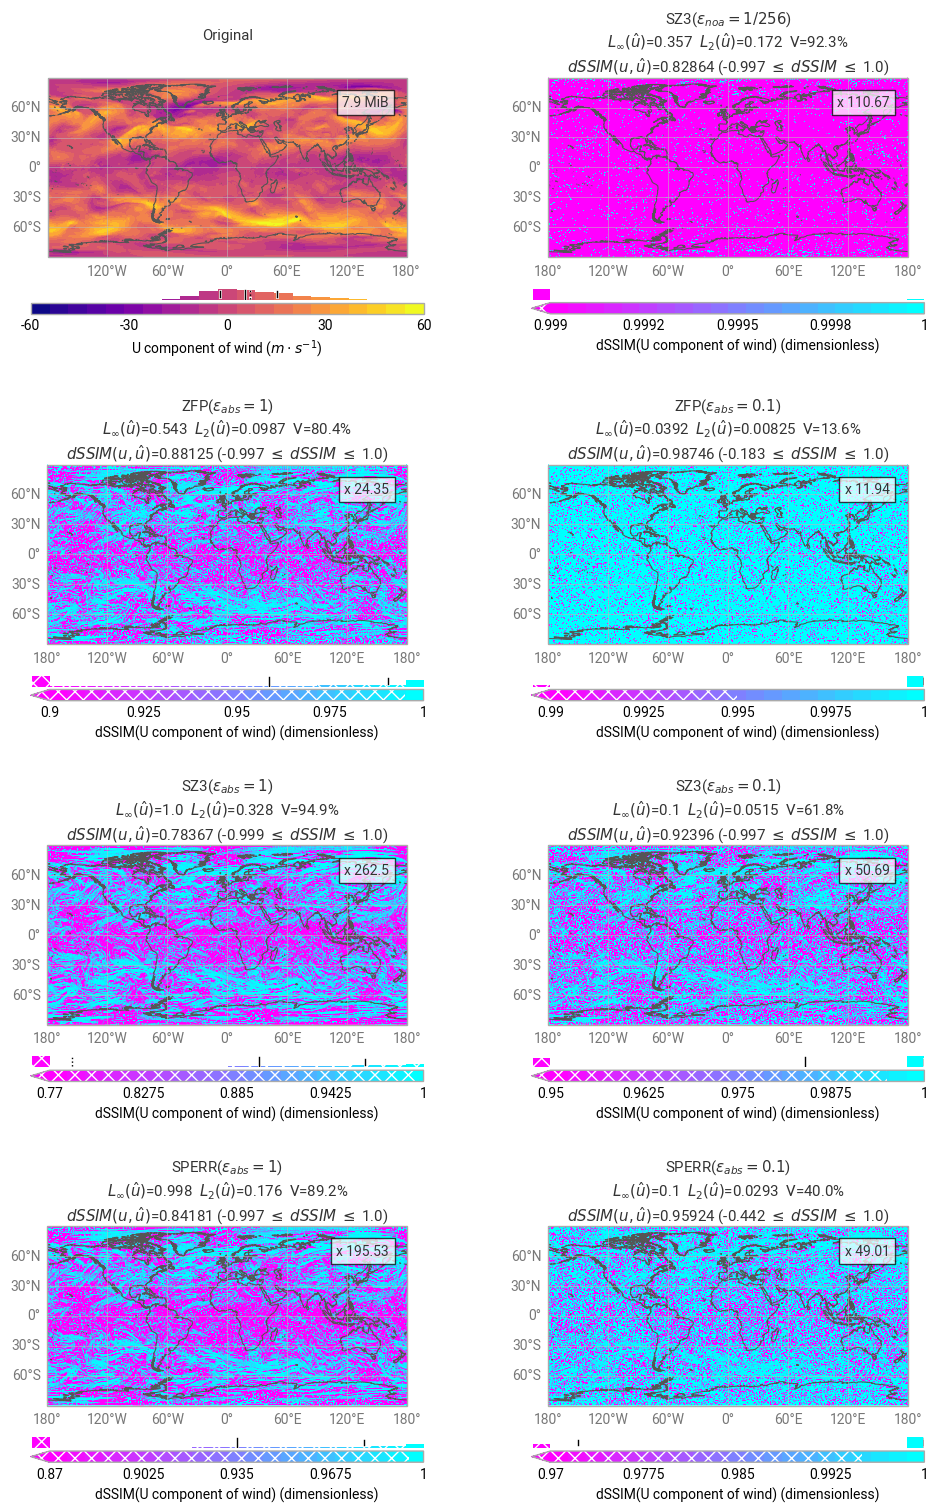

In [25]:
fig = earthkit.plots.Figure(
    size=(10, 15),
    rows=4,
    columns=2,
    hspace=0.1,
)

plot_u_wind_dssim(
    ERA5_U, 1.0, fig.add_map(0, 0), "Original", span=(-60, 60), dssim_bound=dssim_bound
)
plot_u_wind_dssim(
    ERA5_U_codec["zfp.rs"][eb_abs[0]],
    ERA5_U_codec_cr["zfp.rs"][eb_abs[0]],
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}=1$)",
    span=(0.9, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)
plot_u_wind_dssim(
    ERA5_U_codec["sz3.rs"][eb_abs[0]],
    ERA5_U_codec_cr["sz3.rs"][eb_abs[0]],
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}=1$)",
    span=(0.77, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)
plot_u_wind_dssim(
    ERA5_U_codec["sperr.rs"][eb_abs[0]],
    ERA5_U_codec_cr["sperr.rs"][eb_abs[0]],
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}=1$)",
    span=(0.87, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)

plot_u_wind_dssim(
    ERA5_U_noa,
    ERA5_U_noa_cr,
    fig.add_map(0, 1),
    r"SZ3($\epsilon_{{noa}}=1/256$)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)
plot_u_wind_dssim(
    ERA5_U_codec["zfp.rs"][eb_abs[1]],
    ERA5_U_codec_cr["zfp.rs"][eb_abs[1]],
    fig.add_map(1, 1),
    r"ZFP($\epsilon_{{abs}}=0.1$)",
    span=(0.99, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)
plot_u_wind_dssim(
    ERA5_U_codec["sz3.rs"][eb_abs[1]],
    ERA5_U_codec_cr["sz3.rs"][eb_abs[1]],
    fig.add_map(2, 1),
    r"SZ3($\epsilon_{{abs}}=0.1$)",
    span=(0.95, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)
plot_u_wind_dssim(
    ERA5_U_codec["sperr.rs"][eb_abs[1]],
    ERA5_U_codec_cr["sperr.rs"][eb_abs[1]],
    fig.add_map(3, 1),
    r"SPERR($\epsilon_{{abs}}=0.1$)",
    span=(0.97, 1.0),
    dssim_bound=dssim_bound,
    error=True,
)

fig.save("dssim-codec.pdf")

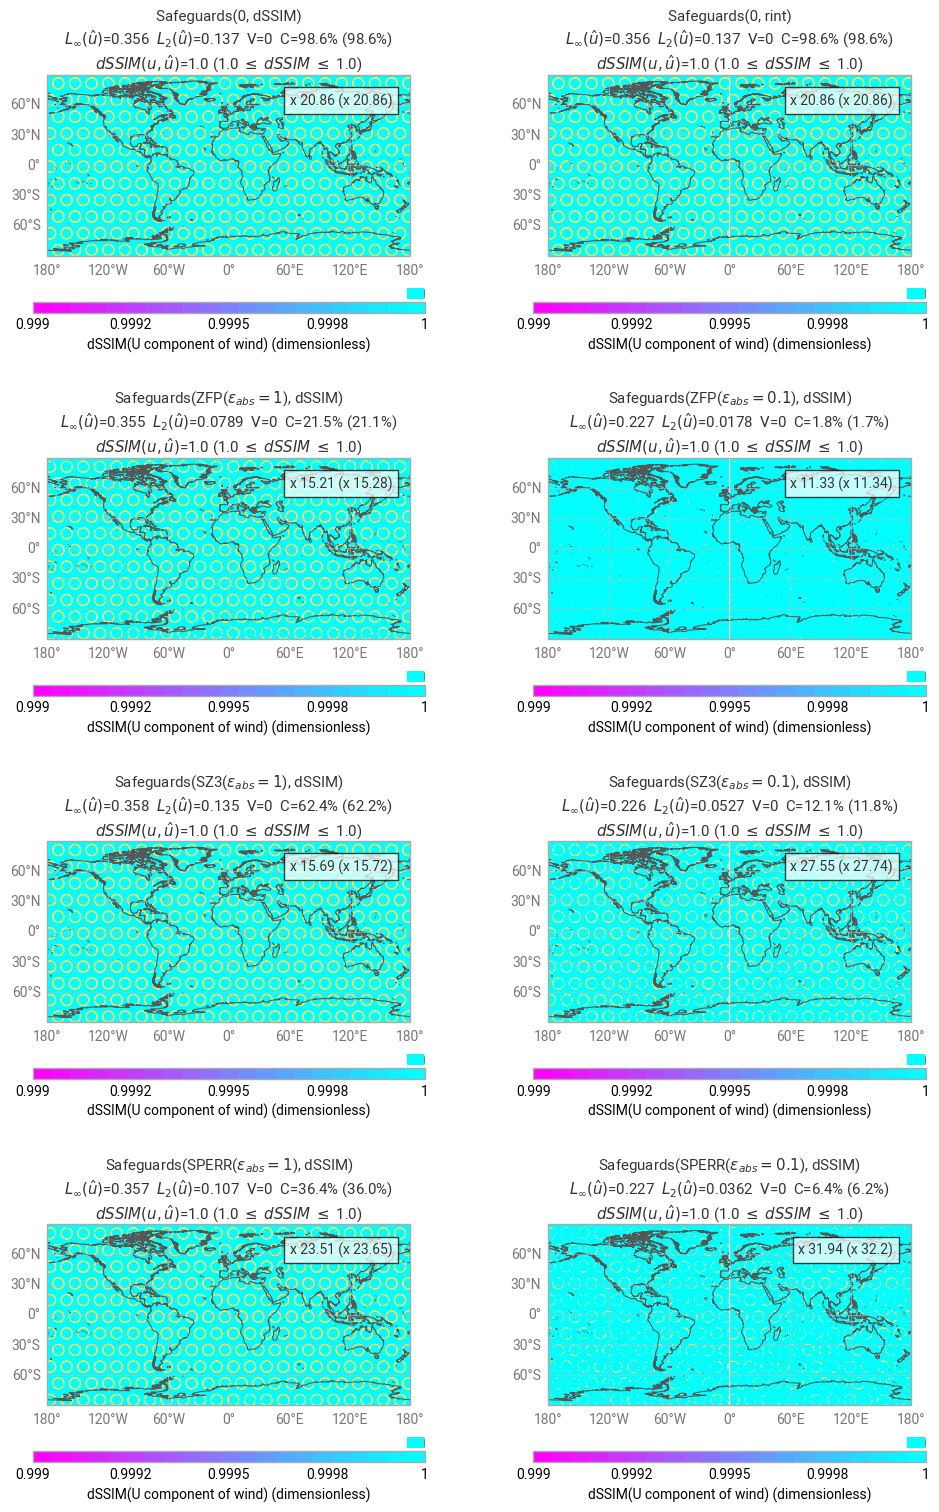

In [26]:
fig = earthkit.plots.Figure(
    size=(10, 15),
    rows=4,
    columns=2,
    hspace=0.1,
)

plot_u_wind_dssim(
    ERA5_U_sg["zero"][eb_abs[0]],
    ERA5_U_sg_cr["zero"][eb_abs[0]],
    fig.add_map(0, 0),
    r"Safeguards(0, dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["zero"][eb_abs[0]],
    my_ERA5_U_it=ERA5_U_sg_it["zero"][eb_abs[0]],
    cr_it=ERA5_U_sg_it_cr["zero"][eb_abs[0]],
)
plot_u_wind_dssim(
    ERA5_U_sg["zfp.rs"][eb_abs[0]],
    ERA5_U_sg_cr["zfp.rs"][eb_abs[0]],
    fig.add_map(1, 0),
    r"Safeguards(ZFP($\epsilon_{{abs}}=1$), dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["zfp.rs"][eb_abs[0]],
    my_ERA5_U_it=ERA5_U_sg_it["zfp.rs"][eb_abs[0]],
    cr_it=ERA5_U_sg_it_cr["zfp.rs"][eb_abs[0]],
)
plot_u_wind_dssim(
    ERA5_U_sg["sz3.rs"][eb_abs[0]],
    ERA5_U_sg_cr["sz3.rs"][eb_abs[0]],
    fig.add_map(2, 0),
    r"Safeguards(SZ3($\epsilon_{{abs}}=1$), dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["sz3.rs"][eb_abs[0]],
    my_ERA5_U_it=ERA5_U_sg_it["sz3.rs"][eb_abs[0]],
    cr_it=ERA5_U_sg_it_cr["sz3.rs"][eb_abs[0]],
)
plot_u_wind_dssim(
    ERA5_U_sg["sperr.rs"][eb_abs[0]],
    ERA5_U_sg_cr["sperr.rs"][eb_abs[0]],
    fig.add_map(3, 0),
    r"Safeguards(SPERR($\epsilon_{{abs}}=1$), dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["sperr.rs"][eb_abs[0]],
    my_ERA5_U_it=ERA5_U_sg_it["sperr.rs"][eb_abs[0]],
    cr_it=ERA5_U_sg_it_cr["sperr.rs"][eb_abs[0]],
)

plot_u_wind_dssim(
    ERA5_U_sg_rint,
    ERA5_U_sg_rint_cr,
    fig.add_map(0, 1),
    r"Safeguards(0, rint)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["zero"][eb_abs[0]],
    my_ERA5_U_it=ERA5_U_sg_it_rint,
    cr_it=ERA5_U_sg_it_rint_cr,
)
plot_u_wind_dssim(
    ERA5_U_sg["zfp.rs"][eb_abs[1]],
    ERA5_U_sg_cr["zfp.rs"][eb_abs[1]],
    fig.add_map(1, 1),
    r"Safeguards(ZFP($\epsilon_{{abs}}=0.1$), dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["zfp.rs"][eb_abs[1]],
    my_ERA5_U_it=ERA5_U_sg_it["zfp.rs"][eb_abs[1]],
    cr_it=ERA5_U_sg_it_cr["zfp.rs"][eb_abs[1]],
)
plot_u_wind_dssim(
    ERA5_U_sg["sz3.rs"][eb_abs[1]],
    ERA5_U_sg_cr["sz3.rs"][eb_abs[1]],
    fig.add_map(2, 1),
    r"Safeguards(SZ3($\epsilon_{{abs}}=0.1$), dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["sz3.rs"][eb_abs[1]],
    my_ERA5_U_it=ERA5_U_sg_it["sz3.rs"][eb_abs[1]],
    cr_it=ERA5_U_sg_it_cr["sz3.rs"][eb_abs[1]],
)
plot_u_wind_dssim(
    ERA5_U_sg["sperr.rs"][eb_abs[1]],
    ERA5_U_sg_cr["sperr.rs"][eb_abs[1]],
    fig.add_map(3, 1),
    r"Safeguards(SPERR($\epsilon_{{abs}}=0.1$), dSSIM)",
    span=(0.999, 1.0),
    dssim_bound=dssim_bound,
    error=True,
    corr=ERA5_U_codec["sperr.rs"][eb_abs[1]],
    my_ERA5_U_it=ERA5_U_sg_it["sperr.rs"][eb_abs[1]],
    cr_it=ERA5_U_sg_it_cr["sperr.rs"][eb_abs[1]],
)

fig.save("dssim-sg.pdf")

In [27]:
dssim_sg_table = pd.concat(
    [
        table_u_wind_dssim(
            ERA5_U_sg["zero"][eb_abs[0]],
            ERA5_U_sg_cr["zero"][eb_abs[0]],
            r"Safeguards(0, dSSIM)",
            dssim_bound,
            ERA5_U_codec["zero"][eb_abs[0]],
            ERA5_U_sg_it["zero"][eb_abs[0]],
            ERA5_U_sg_it_cr["zero"][eb_abs[0]],
        ),
        table_u_wind_dssim(
            ERA5_U_sg["zfp.rs"][eb_abs[0]],
            ERA5_U_sg_cr["zfp.rs"][eb_abs[0]],
            r"Safeguards(ZFP($\epsilon_{{abs}}=1$), dSSIM)",
            dssim_bound,
            ERA5_U_codec["zfp.rs"][eb_abs[0]],
            ERA5_U_sg_it["zfp.rs"][eb_abs[0]],
            ERA5_U_sg_it_cr["zfp.rs"][eb_abs[0]],
        ),
        table_u_wind_dssim(
            ERA5_U_sg["zfp.rs"][eb_abs[1]],
            ERA5_U_sg_cr["zfp.rs"][eb_abs[1]],
            r"Safeguards(ZFP($\epsilon_{{abs}}=0.1$), dSSIM)",
            dssim_bound,
            ERA5_U_codec["zfp.rs"][eb_abs[1]],
            ERA5_U_sg_it["zfp.rs"][eb_abs[1]],
            ERA5_U_sg_it_cr["zfp.rs"][eb_abs[1]],
        ),
        table_u_wind_dssim(
            ERA5_U_sg["sz3.rs"][eb_abs[0]],
            ERA5_U_sg_cr["sz3.rs"][eb_abs[0]],
            r"Safeguards(SZ3($\epsilon_{{abs}}=1$), dSSIM)",
            dssim_bound,
            ERA5_U_codec["sz3.rs"][eb_abs[0]],
            ERA5_U_sg_it["sz3.rs"][eb_abs[0]],
            ERA5_U_sg_it_cr["sz3.rs"][eb_abs[0]],
        ),
        table_u_wind_dssim(
            ERA5_U_sg["sz3.rs"][eb_abs[1]],
            ERA5_U_sg_cr["sz3.rs"][eb_abs[1]],
            r"Safeguards(SZ3($\epsilon_{{abs}}=0.1$), dSSIM)",
            dssim_bound,
            ERA5_U_codec["sz3.rs"][eb_abs[1]],
            ERA5_U_sg_it["sz3.rs"][eb_abs[1]],
            ERA5_U_sg_it_cr["sz3.rs"][eb_abs[1]],
        ),
        table_u_wind_dssim(
            ERA5_U_sg["sperr.rs"][eb_abs[0]],
            ERA5_U_sg_cr["sperr.rs"][eb_abs[0]],
            r"Safeguards(SPERR($\epsilon_{{abs}}=1$), dSSIM)",
            dssim_bound,
            ERA5_U_codec["sperr.rs"][eb_abs[0]],
            ERA5_U_sg_it["sperr.rs"][eb_abs[0]],
            ERA5_U_sg_it_cr["sperr.rs"][eb_abs[0]],
        ),
        table_u_wind_dssim(
            ERA5_U_sg["sperr.rs"][eb_abs[1]],
            ERA5_U_sg_cr["sperr.rs"][eb_abs[1]],
            r"Safeguards(SPERR($\epsilon_{{abs}}=0.1$), dSSIM)",
            dssim_bound,
            ERA5_U_codec["sperr.rs"][eb_abs[1]],
            ERA5_U_sg_it["sperr.rs"][eb_abs[1]],
            ERA5_U_sg_it_cr["sperr.rs"][eb_abs[1]],
        ),
    ]
).set_index(["Compressor", "Safeguards"])

dssim_sg_table.to_latex("dssim-sg.tex", escape=True)

dssim_sg_table

$L_{\infty}(\hat{u})$  \
Compressor                                       Safeguards                         
Safeguards(0, dSSIM)                             one-shot                   0.356   
                                                 iterative                  0.356   
Safeguards(ZFP($\epsilon_{{abs}}=1$), dSSIM)     one-shot                   0.355   
                                                 iterative                  0.469   
Safeguards(ZFP($\epsilon_{{abs}}=0.1$), dSSIM)   one-shot                   0.227   
                                                 iterative                  0.227   
Safeguards(SZ3($\epsilon_{{abs}}=1$), dSSIM)     one-shot                   0.358   
                                                 iterative                  0.973   
Safeguards(SZ3($\epsilon_{{abs}}=0.1$), dSSIM)   one-shot                   0.226   
                                                 iterative                  0.226   
Safeguards(SPERR($\epsilon_{{abs}}=1$), dSSIM)   one-shot                   0.357   
                                                 iterative                  0.808   
Safeguards(SPERR($\epsilon_{{abs}}=0.1$), dSSIM) one-shot                   0.227   
                                                 iterative                  0.227   

                                                            $L_{2}(\hat{u})$  \
Compressor                                       Safeguards                    
Safeguards(0, dSSIM)                             one-shot              0.137   
                                                 iterative             0.137   
Safeguards(ZFP($\epsilon_{{abs}}=1$), dSSIM)     one-shot             0.0789   
                                                 iterative            0.0794   
Safeguards(ZFP($\epsilon_{{abs}}=0.1$), dSSIM)   one-shot             0.0178   
                                                 iterative            0.0175   
Safeguards(SZ3($\epsilon_{{abs}}=1$), dSSIM)     one-shot              0.135   
                                                 iterative             0.136   
Safeguards(SZ3($\epsilon_{{abs}}=0.1$), dSSIM)   one-shot             0.0527   
                                                 iterative            0.0527   
Safeguards(SPERR($\epsilon_{{abs}}=1$), dSSIM)   one-shot              0.107   
                                                 iterative             0.108   
Safeguards(SPERR($\epsilon_{{abs}}=0.1$), dSSIM) one-shot             0.0362   
                                                 iterative             0.036   

                                                            $dSSIM(u, \hat{u})$  \
Compressor                                       Safeguards                       
Safeguards(0, dSSIM)                             one-shot                   1.0   
                                                 iterative                  1.0   
Safeguards(ZFP($\epsilon_{{abs}}=1$), dSSIM)     one-shot                   1.0   
                                                 iterative              0.99996   
Safeguards(ZFP($\epsilon_{{abs}}=0.1$), dSSIM)   one-shot                   1.0   
                                                 iterative              0.99999   
Safeguards(SZ3($\epsilon_{{abs}}=1$), dSSIM)     one-shot                   1.0   
                                                 iterative              0.99998   
Safeguards(SZ3($\epsilon_{{abs}}=0.1$), dSSIM)   one-shot                   1.0   
                                                 iterative              0.99996   
Safeguards(SPERR($\epsilon_{{abs}}=1$), dSSIM)   one-shot                   1.0   
                                                 iterative              0.99996   
Safeguards(SPERR($\epsilon_{{abs}}=0.1$), dSSIM) one-shot                   1.0   
                                                 iterative              0.99997   

                                                            min(dSSIM)  \
Compressor     